In [2]:
import pandas as pd
import re
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import TruncatedSVD

import warnings
warnings.filterwarnings("ignore")

In [3]:
file_path = 'food_coded.csv'
data = pd.read_csv(file_path)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 60 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   GPA                         123 non-null    object 
 1   Gender                      125 non-null    int64  
 2   breakfast                   125 non-null    int64  
 3   calories_chicken            125 non-null    int64  
 4   calories_day                106 non-null    float64
 5   calories_scone              124 non-null    float64
 6   coffee                      125 non-null    int64  
 7   comfort_food                124 non-null    object 
 8   comfort_food_reasons        123 non-null    object 
 9   comfort_food_reasons_coded  106 non-null    float64
 10  cook                        122 non-null    float64
 11  cuisine                     108 non-null    float64
 12  diet_current                124 non-null    object 
 13  diet_current_coded          125 non

In [4]:
def extract_numeric(value):
    if isinstance(value, str):
        match = re.search(r'(\d+\.?\d*)', value)
        if match:
            return float(match.group(1))
        else:
            return None
    else:
        return value

data["GPA"] = data["GPA"].apply(extract_numeric).astype(float)
print(data["GPA"])

0      2.400
1      3.654
2      3.300
3      3.200
4      3.500
       ...  
120    3.500
121    3.000
122    3.882
123    3.000
124    3.900
Name: GPA, Length: 125, dtype: float64


In [5]:
obj = (data.dtypes == 'object')
object_cols = list(obj[obj].index)
print("Categorical variables:",len(object_cols))
 
int_ = (data.dtypes == 'int64')
num_cols = list(int_[int_].index)
print("Integer variables:",len(num_cols))
 
fl = (data.dtypes == 'float')
fl_cols = list(fl[fl].index)
print("Float variables:",len(fl_cols))

Categorical variables: 13
Integer variables: 26
Float variables: 21


In [6]:
new_data_cols=['GPA','income','Gender','employment','grade_level','marital_status']
new_data1=data[new_data_cols]
print(new_data1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GPA             121 non-null    float64
 1   income          124 non-null    float64
 2   Gender          125 non-null    int64  
 3   employment      116 non-null    float64
 4   grade_level     125 non-null    int64  
 5   marital_status  124 non-null    float64
dtypes: float64(4), int64(2)
memory usage: 6.0 KB
None


In [14]:
new_data_cleaned=new_data1.copy()
new_data_cleaned['GPA'] = new_data_cleaned["GPA"].fillna(new_data_cleaned['GPA'].mean())
numeric_cols = new_data_cleaned.select_dtypes(include=['float64', 'int64']).columns
numeric_cols=numeric_cols.drop('GPA')
new_data_cleaned[numeric_cols] = new_data_cleaned[numeric_cols].fillna(new_data_cleaned[numeric_cols].median())

In [15]:
rating_cols=['income']
cat_cols=['Gender','employment','grade_level','marital_status']

In [16]:
new_data_cleaned[numeric_cols]=new_data_cleaned[numeric_cols].astype('Int64')
print(new_data_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GPA             125 non-null    float64
 1   income          125 non-null    Int64  
 2   Gender          125 non-null    Int64  
 3   employment      125 non-null    Int64  
 4   grade_level     125 non-null    Int64  
 5   marital_status  125 non-null    Int64  
dtypes: Int64(5), float64(1)
memory usage: 6.6 KB
None


In [17]:
new_data_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 125 entries, 0 to 124
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   GPA             125 non-null    float64
 1   income          125 non-null    Int64  
 2   Gender          125 non-null    Int64  
 3   employment      125 non-null    Int64  
 4   grade_level     125 non-null    Int64  
 5   marital_status  125 non-null    Int64  
dtypes: Int64(5), float64(1)
memory usage: 6.6 KB


<Axes: >

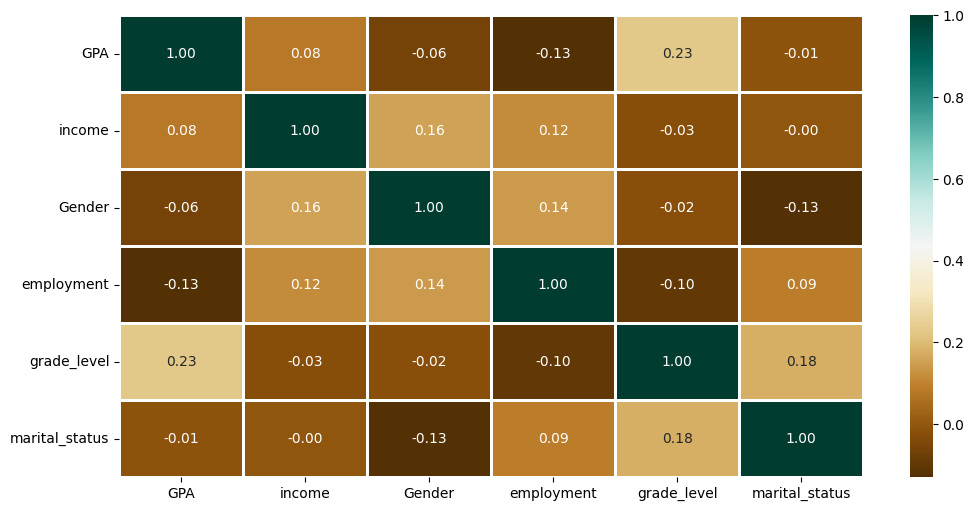

In [18]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(new_data_cleaned.corr(),
            cmap = 'BrBG',
            fmt = '.2f',
            linewidths = 2,
            annot = True)

<Axes: >

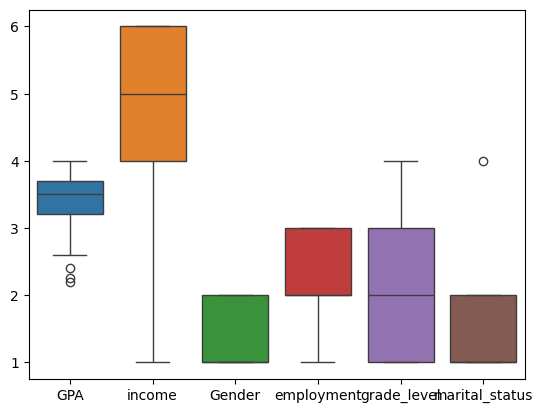

In [19]:
sns.boxplot(data=new_data_cleaned)

<Axes: >

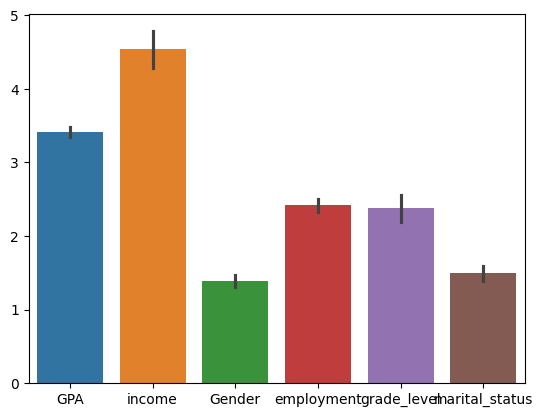

In [20]:
sns.barplot(data=new_data_cleaned)

In [21]:
for col in numeric_cols:
    print(new_data_cleaned[col].skew())
    print(new_data_cleaned[col].kurtosis())
new_data_cleaned['GPA'].skew()
new_data_cleaned['GPA'].kurtosis()

-0.8371417442017081
-0.18389340556772016
0.44783668425063766
-1.8289676610558787
0.00616852901853627
-1.2682132602469158
0.16112007603300582
-1.3703795759175983
0.7627396280421641
1.339992021578022


0.4365838936540678

In [22]:
colms=new_data_cleaned.columns
print(colms)
enc_data=[]
#print(extr_data1.info())
for col in cat_cols:
    #df_one_hot_encoded = pd.get_dummies(extr_data1, columns=[col], prefix=col)
    df_one_hot_encoded = pd.get_dummies(new_data_cleaned[col], prefix=col)
    #df_one_hot_encoded = df_one_hot_encoded.astype(int)
    df_one_hot_encoded = df_one_hot_encoded.applymap(lambda x: 1 if x else 0)
    enc_data.append(df_one_hot_encoded)

final_encoded_data=enc_data.append(new_data_cleaned[['income']])
final_encoded_data = pd.concat(enc_data, axis=1)

print(final_encoded_data)

Index(['GPA', 'income', 'Gender', 'employment', 'grade_level',
       'marital_status'],
      dtype='object')
     Gender_1  Gender_2  employment_1  employment_2  employment_3  \
0           0         1             0             0             1   
1           1         0             0             1             0   
2           1         0             0             0             1   
3           1         0             0             0             1   
4           1         0             0             1             0   
..        ...       ...           ...           ...           ...   
120         1         0             1             0             0   
121         1         0             0             0             1   
122         1         0             0             0             1   
123         0         1             0             1             0   
124         1         0             0             1             0   

     grade_level_1  grade_level_2  grade_level_3  grade_leve

In [23]:
final_encoded_data=final_encoded_data.drop(['Gender_2','employment_1','grade_level_4','marital_status_4'],axis=1)
print(final_encoded_data.columns)
for col in final_encoded_data.columns:
    print(col)
    print(final_encoded_data[col].skew())
    print(final_encoded_data[col].kurtosis())
#new_data_cleaned['GPA'].skew()
#new_data_cleaned['GPA'].kurtosis()

Index(['Gender_1', 'employment_2', 'employment_3', 'grade_level_1',
       'grade_level_2', 'grade_level_3', 'marital_status_1',
       'marital_status_2', 'income'],
      dtype='object')
Gender_1
-0.44783668425063694
-1.8289676610558785
employment_2
-0.21168278032754176
-1.9872485788293381
employment_3
0.2778968376739379
-1.9543043502473816
grade_level_1
0.9046669312815184
-1.2010552044538454
grade_level_2
1.131811517879916
-0.7309576169532206
grade_level_3
1.340123878510096
-0.2076488992032064
marital_status_1
-0.08103981454002579
-2.0261126318703284
marital_status_2
0.11354311483210218
-2.0196851921789065
income
-0.8371417442017081
-0.18389340556772016


1 [0.6686690846801767, 0.7174648292037165, 0.7902779156620126, 0.8944191863873677, 0.9315949909653857, 0.8269576132670297, 0.7276070883756914, 0.681055052280606]
6
Silhouette Score with optimal k: 0.93
Davies-Bouldin Index with optimal k: 0.09
2 [0.5000367647453402, 0.44667751294352964, 0.4622468460755671, 0.49318655506879905, 0.5342588609929214, 0.5668297241454704, 0.5902152787644306, 0.6405298228475006]
9
Silhouette Score with optimal k: 0.64
Davies-Bouldin Index with optimal k: 0.52
3 [0.4178206965892699, 0.2984933479012777, 0.34398370130385625, 0.34255578132759595, 0.40683973821698943, 0.47663107552118833, 0.5007461752588493, 0.5148396910259938]
9
Silhouette Score with optimal k: 0.51
Davies-Bouldin Index with optimal k: 0.74
4 [0.3806321338747107, 0.3067200276910928, 0.2837381861675356, 0.28710113380703495, 0.32294176664462426, 0.34702774758921484, 0.3683872390063661, 0.37712333382661123]
2
Silhouette Score with optimal k: 0.38
Davies-Bouldin Index with optimal k: 1.06
5 [0.353928

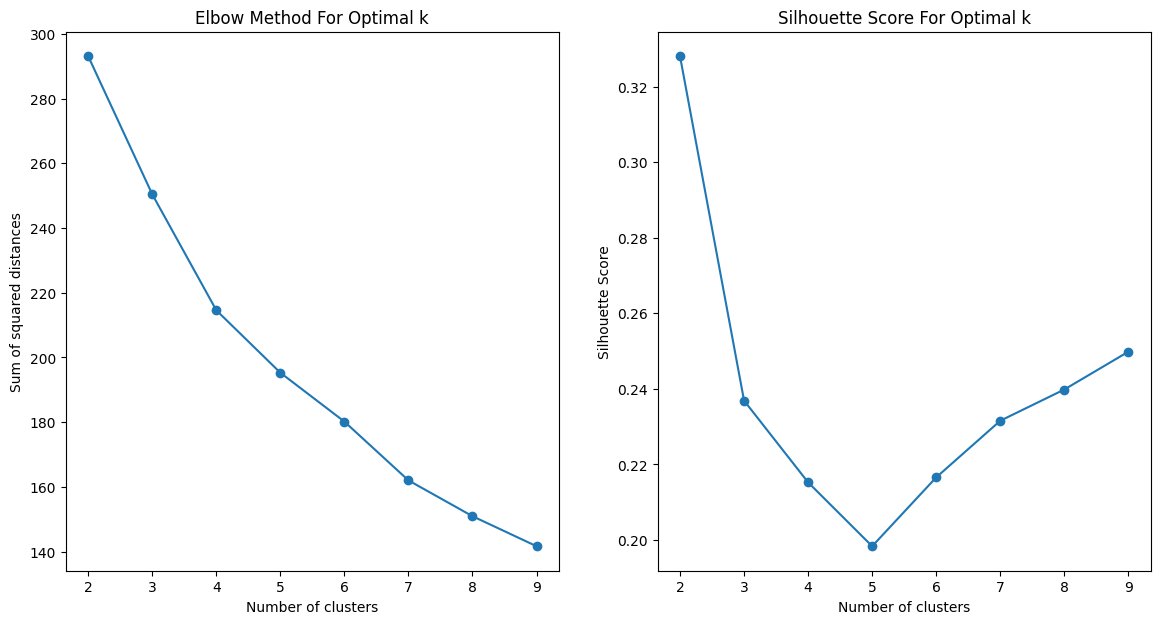

6
Silhouette Score with optimal k: 0.43
Davies-Bouldin Index with optimal k: 0.97


In [50]:
data_processed=final_encoded_data.copy()
sse = []
silhouette_scores = []
k_range = range(2, 10)
from sklearn.decomposition import PCA
ns=range(1,10)

for n in ns:
    data_processed=final_encoded_data.copy()
    pca = PCA(n_components=n)
    X_train_pca = pca.fit_transform(data_processed)
    sse = []
    silhouette_scores = []
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_train_pca)
        sse.append(kmeans.inertia_)
        silhouette_avg = silhouette_score(X_train_pca, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
    print(n,silhouette_scores)
    optimal_k = k_range[silhouette_scores.index(max(silhouette_scores))]
    # Fit K-Means with the optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_k, random_state=42)
    kmeans.fit(X_train_pca)
    data_processed['cluster'] = kmeans.labels_
    print(optimal_k)
    # Calculate silhouette score for the optimal number of clusters
    silhouette_avg = silhouette_score(X_train_pca, data_processed['cluster'])
    print(f'Silhouette Score with optimal k: {silhouette_avg:.2f}')
    
    # Calculate Davies-Bouldin Index for the optimal number of clusters
    db_score = davies_bouldin_score(X_train_pca, data_processed['cluster'])
    print(f'Davies-Bouldin Index with optimal k: {db_score:.2f}')
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')

plt.show()


pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(data_processed.drop('cluster',axis=1))
# Choose the optimal number of clusters from the above plot
optimal_k = 6
# Fit K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_train_pca)
data_processed['cluster'] = kmeans.labels_
print(optimal_k)
# Calculate silhouette score for the optimal number of clusters
silhouette_avg = silhouette_score(data_processed, data_processed['cluster'])
print(f'Silhouette Score with optimal k: {silhouette_avg:.2f}')

# Calculate Davies-Bouldin Index for the optimal number of clusters
db_score = davies_bouldin_score(data_processed, data_processed['cluster'])
print(f'Davies-Bouldin Index with optimal k: {db_score:.2f}')


2 [0.5000367647453402, 0.44667751294352964, 0.4622468460755671, 0.49318655506879905, 0.5342588609929214, 0.5668297241454704, 0.5902152787644306, 0.6405298228475006, 0.6625130474476381]
6
Silhouette Score with optimal k: 0.53
Davies-Bouldin Index with optimal k: 0.74


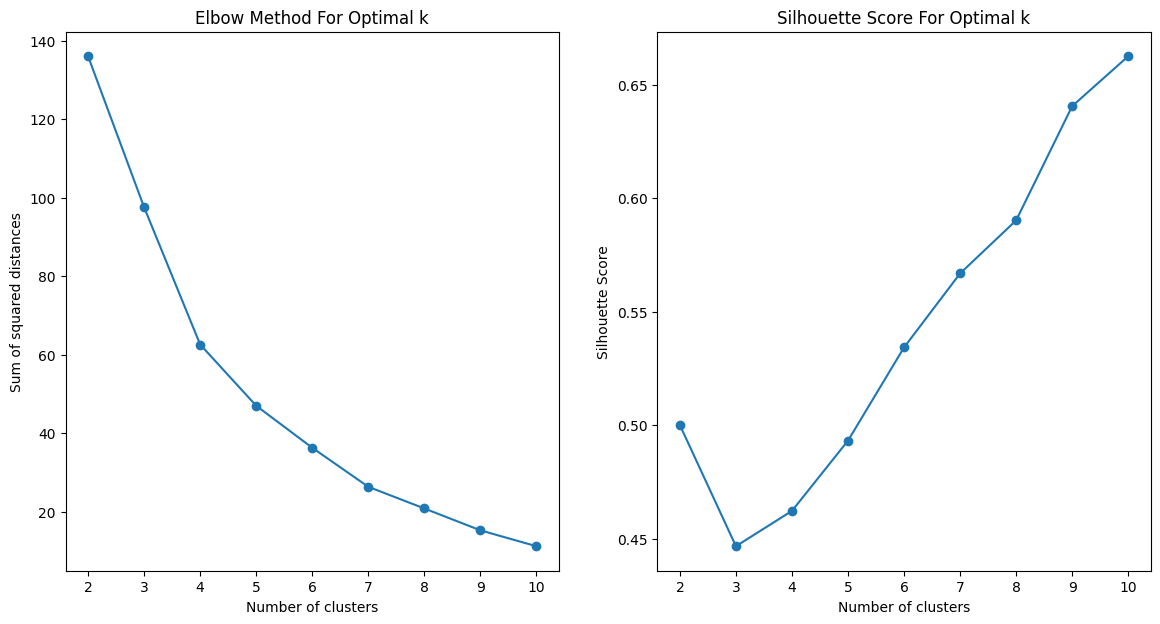

In [30]:
data_processed=final_encoded_data.copy()
sse = []
silhouette_scores = []
k_range = range(2, 11)
from sklearn.decomposition import PCA
ns=[2,4,8]
n=2
pca = PCA(n_components=n)
X_train_pca = pca.fit_transform(data_processed)
sse = []
silhouette_scores = []
for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(X_train_pca)
        sse.append(kmeans.inertia_)
        silhouette_avg = silhouette_score(X_train_pca, kmeans.labels_)
        silhouette_scores.append(silhouette_avg)
print(n,silhouette_scores)
optimal_k = 7
# Fit K-Means with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X_train_pca)
data_processed['cluster'] = kmeans.labels_
print(optimal_k)
# Calculate silhouette score for the optimal number of clusters
silhouette_avg = silhouette_score(X_train_pca, data_processed['cluster'])
print(f'Silhouette Score with optimal k: {silhouette_avg:.2f}')

# Calculate Davies-Bouldin Index for the optimal number of clusters
db_score = davies_bouldin_score(X_train_pca, data_processed['cluster'])
print(f'Davies-Bouldin Index with optimal k: {db_score:.2f}')
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(k_range, sse, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Sum of squared distances')
plt.title('Elbow Method For Optimal k')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')

plt.show()


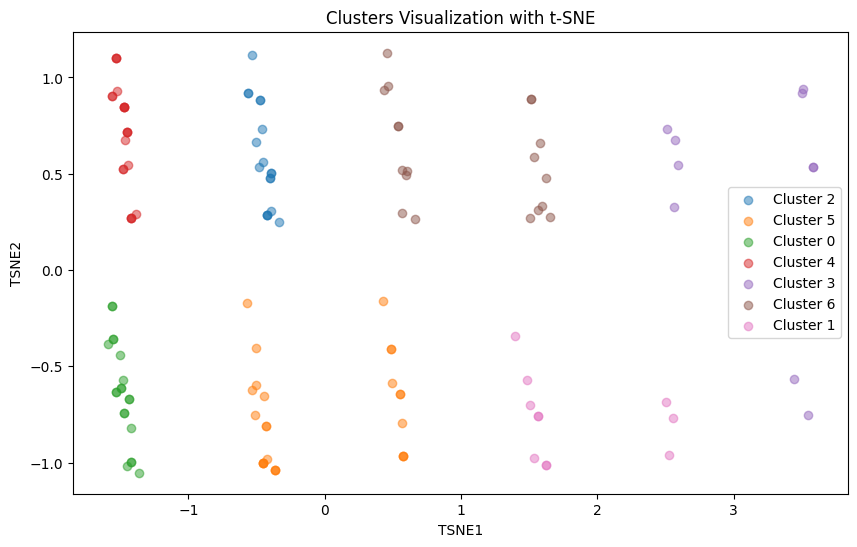

In [39]:
kmeans = KMeans(n_clusters=7, random_state=42)
kmeans.fit(X_train_pca)
data_processed['cluster'] = kmeans.labels_

df_tsne = pd.DataFrame(X_train_pca, columns=['PCA1', 'PCA2'])
df_tsne['cluster'] = data_processed['cluster']

# Plot the clusters using t-SNE
plt.figure(figsize=(10, 6))
for cluster in df_tsne['cluster'].unique():
    cluster_data = df_tsne[df_tsne['cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}', alpha=0.5)
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('Clusters Visualization with t-SNE')
plt.legend()
plt.show()

In [40]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

X = data_processed.iloc[:,:-1]
y = data_processed['cluster']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [41]:
print(X_train)

     Gender_1  employment_2  employment_3  grade_level_1  grade_level_2  \
67          1             1             0              0              1   
12          0             0             1              1              0   
24          1             0             1              0              0   
45          1             1             0              0              1   
108         1             0             1              0              1   
..        ...           ...           ...            ...            ...   
106         1             1             0              1              0   
14          0             0             1              0              0   
92          0             1             0              0              0   
51          0             0             1              0              1   
102         1             0             1              0              1   

     grade_level_3  marital_status_1  marital_status_2  income  
67               0                

In [42]:
duplicates = df_one_hot_encoded[df_one_hot_encoded.duplicated()]
print("Duplicate rows:\n", duplicates)

Duplicate rows:
      marital_status_1  marital_status_2  marital_status_4
2                   0                 1                 0
3                   0                 1                 0
4                   1                 0                 0
5                   0                 1                 0
6                   1                 0                 0
..                ...               ...               ...
120                 1                 0                 0
121                 1                 0                 0
122                 1                 0                 0
123                 1                 0                 0
124                 0                 1                 0

[122 rows x 3 columns]


In [43]:
classifier = RandomForestClassifier(random_state=42)
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
#print("Classification Report:")
#print(report)

Accuracy: 1.0


In [44]:
y_pred_test = classifier.predict(X_test)

# Make predictions on the training set
y_pred_train = classifier.predict(X_train)

# Create DataFrame for test set predictions
df_test_predictions = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_pred_test
})

# Create DataFrame for training set predictions
df_train_predictions = pd.DataFrame({
    'Actual': y_train,
    'Predicted': y_pred_train
})

print("\nTest Set Predictions:")
print(df_test_predictions)

print("\nTraining Set Predictions:")
print(df_train_predictions)

# Evaluate the model
accuracy_test = accuracy_score(y_test, y_pred_test)
accuracy_train = accuracy_score(y_train, y_pred_train)

print(f"\nAccuracy on Test Set: {accuracy_test}")
print(f"Accuracy on Training Set: {accuracy_train}")
print("\nClassification Report (Test Set):")
print(classification_report(y_test, y_pred_test))


Test Set Predictions:
     Actual  Predicted
18        5          5
42        4          4
36        4          4
76        6          6
53        6          6
91        0          0
56        4          4
123       6          6
93        6          6
4         4          4
27        0          0
116       3          3
44        2          2
96        4          4
19        2          2
77        1          1
10        6          6
101       2          2
11        5          5
114       1          1
47        4          4
78        5          5
0         2          2
26        5          5
31        6          6

Training Set Predictions:
     Actual  Predicted
67        5          5
12        5          5
24        5          5
45        0          0
108       0          0
..      ...        ...
106       3          3
14        2          2
92        1          1
51        4          4
102       2          2

[100 rows x 2 columns]

Accuracy on Test Set: 1.0
Accuracy on Training Set:

In [45]:
custom_point = np.array([[1, 1,0,1,0,0,1,0,2],[1, 1,0,1,0,0,1,0,1],[0, 0,1,1,0,0,0,1,6],[1, 0,1,1,0,0,1,0,4],[1, 1,0,1,0,0,1,0,4],[0, 1,0,1,0,0,1,0,4],[1, 1,0,1,0,0,1,0,6],[1, 1,0,1,0,0,0,1,4],[0, 1,0,0,1,0,1,0,3],[0, 1,0,1,0,0,1,0,1],[1, 0,1,1,0,0,0,1,5],[0, 1,0,0,0,1,1,0,3],[1, 0,1,0,1,0,1,0,2]])

# Predict the cluster for the custom point
custom_points_labels = classifier.predict(custom_point)
for i, point in enumerate(custom_point):
    print(f"The custom point {point} is predicted to be in cluster {custom_points_labels[i]}")

The custom point [1 1 0 1 0 0 1 0 2] is predicted to be in cluster 3
The custom point [1 1 0 1 0 0 1 0 1] is predicted to be in cluster 3
The custom point [0 0 1 1 0 0 0 1 6] is predicted to be in cluster 0
The custom point [1 0 1 1 0 0 1 0 4] is predicted to be in cluster 6
The custom point [1 1 0 1 0 0 1 0 4] is predicted to be in cluster 6
The custom point [0 1 0 1 0 0 1 0 4] is predicted to be in cluster 6
The custom point [1 1 0 1 0 0 1 0 6] is predicted to be in cluster 4
The custom point [1 1 0 1 0 0 0 1 4] is predicted to be in cluster 5
The custom point [0 1 0 0 1 0 1 0 3] is predicted to be in cluster 6
The custom point [0 1 0 1 0 0 1 0 1] is predicted to be in cluster 3
The custom point [1 0 1 1 0 0 0 1 5] is predicted to be in cluster 5
The custom point [0 1 0 0 0 1 1 0 3] is predicted to be in cluster 6
The custom point [1 0 1 0 1 0 1 0 2] is predicted to be in cluster 3


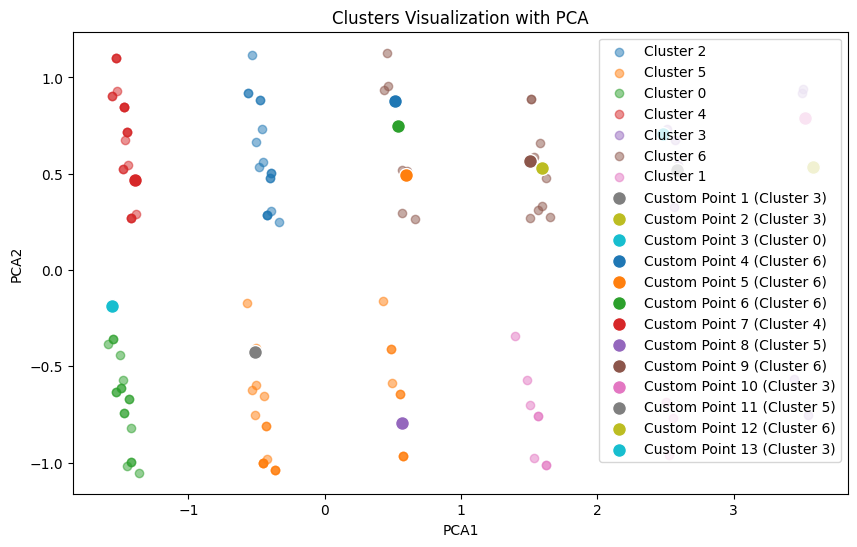

In [46]:
custom_point_pca = pca.transform(custom_point)
df_tsne = pd.DataFrame(X_train_pca, columns=['PCA1', 'PCA2'])
df_tsne['cluster'] = data_processed['cluster']

# Plot the clusters using t-SNE
plt.figure(figsize=(10, 6))
for cluster in df_tsne['cluster'].unique():
    cluster_data = df_tsne[df_tsne['cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}', alpha=0.5)

for i, point in enumerate(custom_point_pca):
    plt.scatter(point[0], point[1], s=100, label=f'Custom Point {i+1} (Cluster {custom_points_labels[i]})', edgecolor='white')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Clusters Visualization with PCA')
plt.legend()
plt.show()